In [37]:
# https://keras.io/examples/timeseries/timeseries_weather_forecasting/
# https://www.researchgate.net/publication/343250071_Recognizing_Emotions_Evoked_by_Music_using_CNN-LSTM_Networks_on_EEG_signals
import pandas as pd
from utils import get_dfs, extract_classes
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras import backend as K
from keras.utils import to_categorical
from tensorflow import keras
from model import run_model
import tensorflow as tf
import tensorflow.keras.layers as tfl
from datetime import timedelta

In [38]:
def select_data_around_event(df_filtered, events, before=0, after=5):
    df_output = None
    for idx in events.loc[events.label=='start'].index:
        start = pd.to_datetime(idx) + timedelta(seconds=before)
        end = pd.to_datetime(idx) + timedelta(seconds=after)
        if df_output is None:
            df_output = df_filtered.loc[(start<=pd.to_datetime(df_filtered.index)) & (pd.to_datetime(df_filtered.index)<=end)]
        else:
            df_output = pd.concat([df_output, df_filtered.loc[(start<=pd.to_datetime(df_filtered.index)) & (pd.to_datetime(df_filtered.index)<=end)]])
        df_output = df_output.drop_duplicates().copy()
    return df_output

In [39]:
hdf_file_path = [
    "../data/20221029-171117.hdf5",
    "../data/20221029-192231.hdf5",
    "../data/20221029-200201.hdf5",
    "../data/20221029-202757.hdf5",
    "../data/othmane_assis_EEG_20221029-231521.hdf5"
]

result_filtered = None
result_events = None

for path in hdf_file_path:
    _, df_events, df_filtered, _ = get_dfs(path)
    df_filtered = select_data_around_event(df_filtered, df_events, before=-2, after=12)
    if result_filtered is None:
        result_filtered = df_filtered
    else:
        result_filtered = pd.concat([result_filtered, df_filtered])

    if result_events is None:
        result_events = df_events
    else:
        result_events = pd.concat([result_events, df_events])
# Clean events to have only 3 classes
result_events.replace('"repos"', 'neutral', inplace=True)
result_events.replace(['"calme"', '"lent"'], 'positive', inplace=True)
result_events.replace(['"rapide"', '"agite"'], 'negative', inplace=True)
result_events = result_events[result_events.data != '"fin"']
result_events = result_events[result_events.data != '"calme"']
result_events = result_events[result_events.data != '"agite"']
result_events = result_events[result_events.data != '"interuption"']

In [40]:
def prepare_ts_for_training(ts_df, event_df):
    df_lag = ts_df.copy()
    for i in range(1, 500):
        df_lag = df_lag.merge(ts_df.shift(i), how='inner', left_index=True, right_index=True, suffixes=('',f'_{i:02d}'))
    ts_df = df_lag.dropna().copy()
    del df_lag

    res = None
    classes = extract_classes(event_df)
    tmp_event_df = event_df.copy()
    for c in range(len(classes)):
        start_events = event_df.loc[(event_df.data == classes[c])]
        ref_start_date = start_events.index[0]
        start = event_df.loc[(event_df.data == classes[c]) & (event_df.label == 'start')].index[0]
        end = event_df.loc[(event_df.data == classes[c]) & (event_df.label == 'stop')].index

        if len(end) == 0:
            end = ts_df.index[-1]
        else:
            end = end[0]

        if c < len(classes) - 2:
            tmp_event_df = tmp_event_df.drop(tmp_event_df.index[0])

        current = ts_df[start:end].head(5000)
        current['class'] = classes[c].replace('"', '')
        if res is None:
            res = current
        else:
            res = pd.concat([res, current])
    return res


In [41]:
final_df = prepare_ts_for_training(df_filtered, df_events)

In [42]:
final_df

,Fpz,Fpz_01,Fpz_02,Fpz_03,Fpz_04,Fpz_05,Fpz_06,Fpz_07,Fpz_08,Fpz_09,...,Fpz_491,Fpz_492,Fpz_493,Fpz_494,Fpz_495,Fpz_496,Fpz_497,Fpz_498,Fpz_499,class
2022-10-29 23:16:38.211257,-3.465246,1.882077,2.907462,1.350266,0.083632,-1.282011,-2.596972,-3.796965,-2.356716,0.715412,...,-0.088205,1.616498,5.270235,6.482084,3.978147,3.227754,4.857337,4.452891,5.095378,repos
2022-10-29 23:16:38.221257,-6.077164,-3.465246,1.882077,2.907462,1.350266,0.083632,-1.282011,-2.596972,-3.796965,-2.356716,...,-0.383773,-0.088205,1.616498,5.270235,6.482084,3.978147,3.227754,4.857337,4.452891,repos
2022-10-29 23:16:38.231257,-4.814511,-6.077164,-3.465246,1.882077,2.907462,1.350266,0.083632,-1.282011,-2.596972,-3.796965,...,0.043241,-0.383773,-0.088205,1.616498,5.270235,6.482084,3.978147,3.227754,4.857337,repos
2022-10-29 23:16:38.241257,-5.202197,-4.814511,-6.077164,-3.465246,1.882077,2.907462,1.350266,0.083632,-1.282011,-2.596972,...,2.151882,0.043241,-0.383773,-0.088205,1.616498,5.270235,6.482084,3.978147,3.227754,repos
2022-10-29 23:16:38.251257,-5.059534,-5.202197,-4.814511,-6.077164,-3.465246,1.882077,2.907462,1.350266,0.083632,-1.282011,...,4.752382,2.151882,0.043241,-0.383773,-0.088205,1.616498,5.270235,6.482084,3.978147,repos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-29 23:17:44.201257,-12.540166,-12.623751,-15.823802,-19.592387,-19.593945,-18.510256,-19.655794,-19.440684,-17.713127,-16.953861,...,10.356130,9.964634,16.155429,20.098663,19.234409,13.719698,11.390698,18.539255,19.518198,repos
2022-10-29 23:17:44.211257,-13.960898,-12.540166,-12.623751,-15.823802,-19.592387,-19.593945,-18.510256,-19.655794,-19.440684,-17.713127,...,17.442992,10.356130,9.964634,16.155429,20.098663,19.234409,13.719698,11.390698,18.539255,repos
2022-10-29 23:17:44.221257,-15.470046,-13.960898,-12.540166,-12.623751,-15.823802,-19.592387,-19.593945,-18.510256,-19.655794,-19.440684,...,18.112759,17.442992,10.356130,9.964634,16.155429,20.098663,19.234409,13.719698,11.390698,repos
2022-10-29 23:17:44.231257,-17.092495,-15.470046,-13.960898,-12.540166,-12.623751,-15.823802,-19.592387,-19.593945,-18.510256,-19.655794,...,14.161674,18.112759,17.442992,10.356130,9.964634,16.155429,20.098663,19.234409,13.719698,repos


In [43]:
split_fraction = 0.715
train_split = int(split_fraction * int(final_df.shape[0]))
step = 200

past = 3000
future = 1000
learning_rate = 0.001
batch_size = 750
epochs = 5

start = past + future
end = start + train_split


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


In [44]:
def load_ds():
    feature_keys = final_df.columns
    print(feature_keys)
    selected_features = [feature_keys[i] for i in range(len(feature_keys))]
    features = final_df[selected_features]

    le = preprocessing.LabelEncoder()
    features['class'] = le.fit_transform(features['class'])
    
    features = normalize(features.values, train_split)
    features = pd.DataFrame(features)
    features[features.columns[-1]] = le.fit_transform(final_df['class'])

    train_data = features.loc[0 : train_split - 1]
    val_data = features.loc[train_split:]


    start = past + future
    end = start + train_split

    x_train = train_data[[i for i in range(len(feature_keys) - 1)]].values
    y_train = features.iloc[start:end][features.columns[-1]]

    sequence_length = int(past / step)

    dataset_train = keras.preprocessing.timeseries_dataset_from_array(
        x_train,
        y_train,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size,
    )

    sequence_length = int(past / step)


    x_end = len(val_data) - past - future
    label_start = train_split + past + future
    x_val = val_data.iloc[:x_end][[i for i in range(len(feature_keys) - 1)]].values
    y_val = features.iloc[label_start:][features.columns[-1]]
    # display(x_val.shape)
    dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,)
    
    return dataset_train, dataset_val

In [45]:
dataset_train, dataset_val = load_ds()


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Index(['Fpz', 'Fpz_01', 'Fpz_02', 'Fpz_03', 'Fpz_04', 'Fpz_05', 'Fpz_06',
       'Fpz_07', 'Fpz_08', 'Fpz_09',
       ...
       'Fpz_491', 'Fpz_492', 'Fpz_493', 'Fpz_494', 'Fpz_495', 'Fpz_496',
       'Fpz_497', 'Fpz_498', 'Fpz_499', 'class'],
      dtype='object', length=501)
Input shape: (750, 15, 500)
Target shape: (750,)


In [46]:
(history, model) = run_model(dataset_train, dataset_val, inputs, num_classes=3, epochs=epochs)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 15, 500)]         0         
                                                                 
 conv1d_24 (Conv1D)          (None, 3, 16)             960016    
                                                                 
 re_lu_33 (ReLU)             (None, 3, 16)             0         
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 2, 16)            0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 2, 32)             1568      
                                                                 
 re_lu_34 (ReLU)             (None, 2, 32)             0         
                                                           

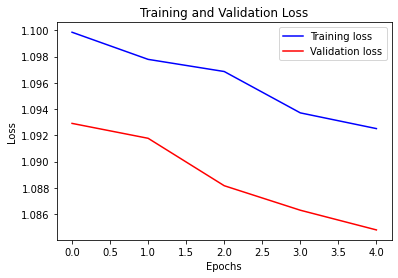

In [47]:
import matplotlib.pyplot as plt
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")


24/24 [==============================] - 1s 6ms/step


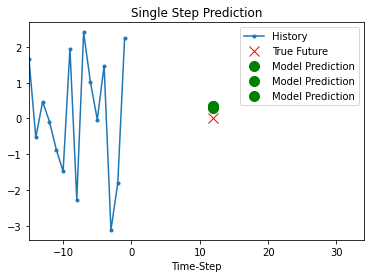

24/24 [==============================] - 0s 5ms/step


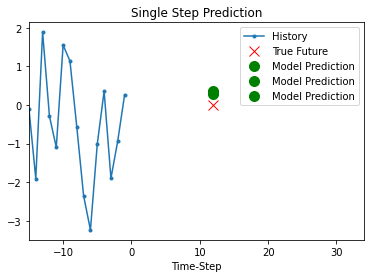

24/24 [==============================] - 0s 6ms/step


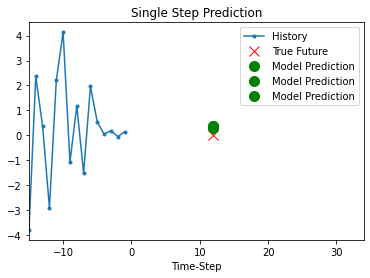

24/24 [==============================] - 0s 6ms/step


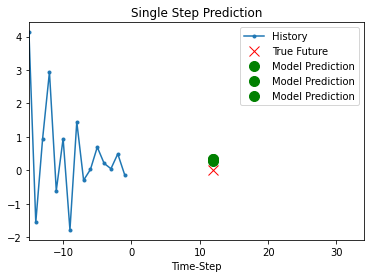

24/24 [==============================] - 0s 6ms/step


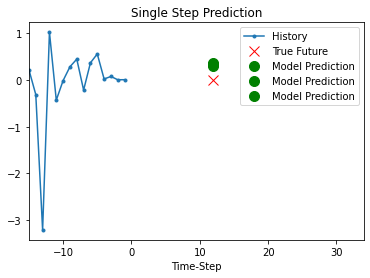

In [48]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )
